# Figures for a Department of Statistics Colloquim at Purdue University
presented on Friday, March 3, 2023

In [23]:
import matplotlib.pyplot as plt
import numpy as np
import qmcpy as qp
import time  #timing routines
import warnings  #to suppress warnings when needed

plt.rc('font', size=16)  #set defaults so that the plots are readable
plt.rc('axes', titlesize=16)
plt.rc('axes', labelsize=16)
plt.rc('xtick', labelsize=16)
plt.rc('ytick', labelsize=16)
plt.rc('legend', fontsize=16)
plt.rc('figure', titlesize=16)

#a helpful plotting method to show increasing numbers of points
def plot_successive_points(distrib,ld_name,first_n=64,n_cols=1,pt_clr='bgkcmy',xlim=[0,1],ylim=[0,1]):
  fig,ax = plt.subplots(nrows=1,ncols=n_cols,figsize=(5*n_cols,5.5))
  if n_cols==1: ax = [ax]
  last_n = first_n*(2**n_cols)
  points = distrib.gen_samples(n=last_n)
  for i in range(n_cols):
    n = first_n
    nstart = 0
    for j in range(i+1):
      n = first_n*(2**j)
      ax[i].scatter(points[nstart:n,0],points[nstart:n,1],color=pt_clr[j])
      nstart = n
    ax[i].set_title('n = %d'%n)
    ax[i].set_xlim(xlim); ax[i].set_xticks(xlim); ax[i].set_xlabel('$x_{i,1}$')
    ax[i].set_ylim(ylim); ax[i].set_yticks(ylim); ax[i].set_ylabel('$x_{i,2}$')
    ax[i].set_aspect((xlim[1]-xlim[0])/(ylim[1]-ylim[0]))
  fig.suptitle('%s Points'%ld_name, y=0.87)
  return fig

print('QMCPy Version',qp.__version__)

#plt.style.use('../qmcpy.mplstyle')
figpath = '/Users/fredhickernell/SoftwareRepositories/Purdue-2023-March-Talk/figures/' #this path sends the figures to my directory

QMCPy Version 1.3.2


## Here are some plots of IID and Low Discrepancy Points
### Lattice points first

[[0.29489468 0.59097909 0.10023203 0.95285496 0.69232324]
 [0.79489468 0.09097909 0.60023203 0.45285496 0.19232324]
 [0.54489468 0.34097909 0.85023203 0.20285496 0.94232324]
 [0.04489468 0.84097909 0.35023203 0.70285496 0.44232324]
 [0.41989468 0.96597909 0.47523203 0.07785496 0.81732324]
 [0.91989468 0.46597909 0.97523203 0.57785496 0.31732324]
 [0.66989468 0.71597909 0.22523203 0.32785496 0.06732324]
 [0.16989468 0.21597909 0.72523203 0.82785496 0.56732324]
 [0.35739468 0.27847909 0.28773203 0.01535496 0.25482324]
 [0.85739468 0.77847909 0.78773203 0.51535496 0.75482324]
 [0.60739468 0.02847909 0.03773203 0.26535496 0.50482324]
 [0.10739468 0.52847909 0.53773203 0.76535496 0.00482324]
 [0.48239468 0.65347909 0.66273203 0.14035496 0.37982324]
 [0.98239468 0.15347909 0.16273203 0.64035496 0.87982324]
 [0.73239468 0.40347909 0.41273203 0.39035496 0.62982324]
 [0.23239468 0.90347909 0.91273203 0.89035496 0.12982324]
 [0.32614468 0.93472909 0.19398203 0.98410496 0.47357324]
 [0.82614468 0

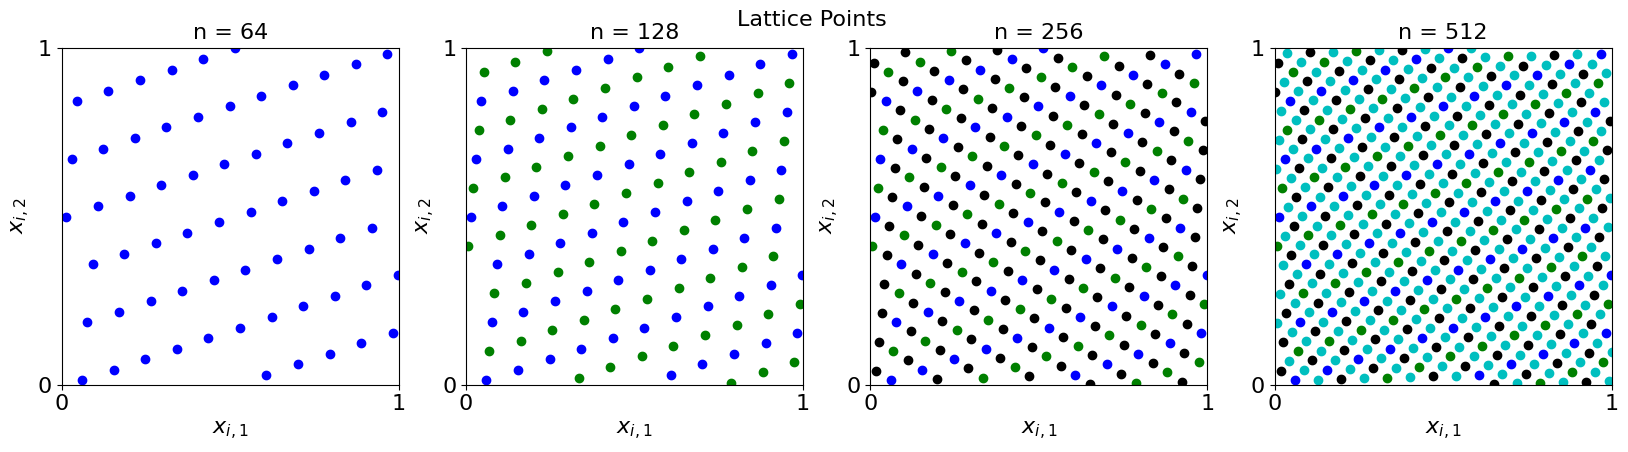

In [24]:
d = 5 #dimension
n = 64 #number of points
ld = qp.Lattice(d) #define the generator
xpts = ld.gen_samples(n) #generate points
print(xpts)
fig = plot_successive_points(ld,'Lattice',first_n=n,n_cols=4)
fig.savefig(figpath+'latticepts.eps',format='eps')

### Next Sobol' points

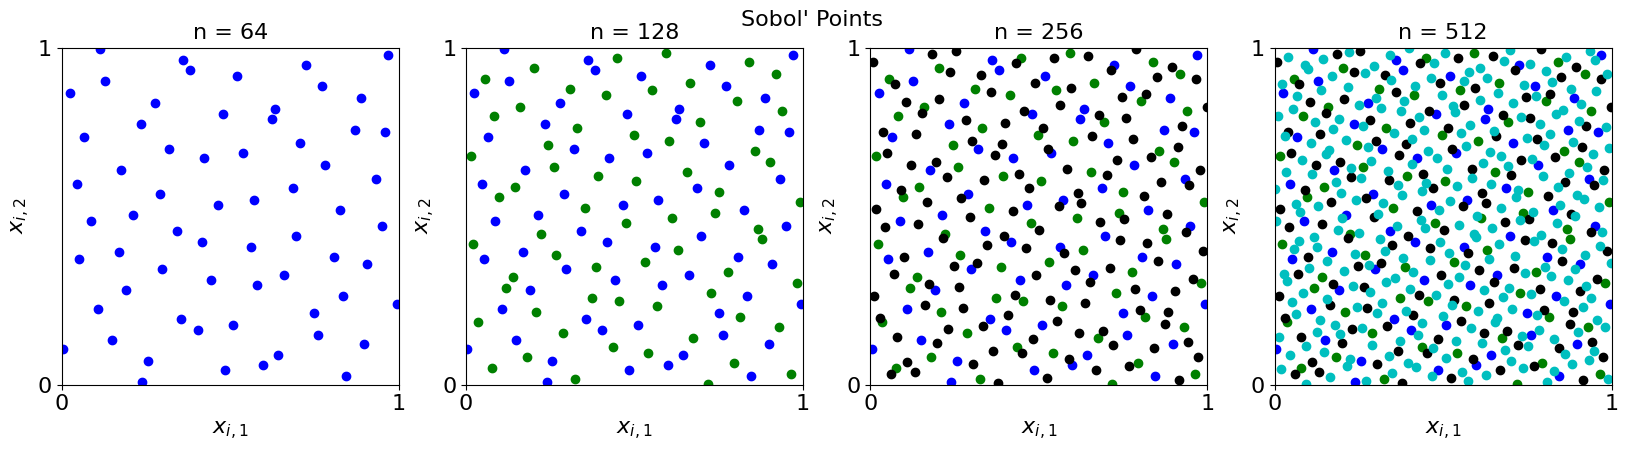

In [25]:
ld = qp.Sobol(d) #define the generator
xpts = ld.gen_samples(n) #generate points
xpts
fig = plot_successive_points(ld,'Sobol\'',first_n=n,n_cols=4)
fig.savefig(figpath+'sobolpts.eps',format='eps')

### Compare to IID

Note that there are more gaps and clusters

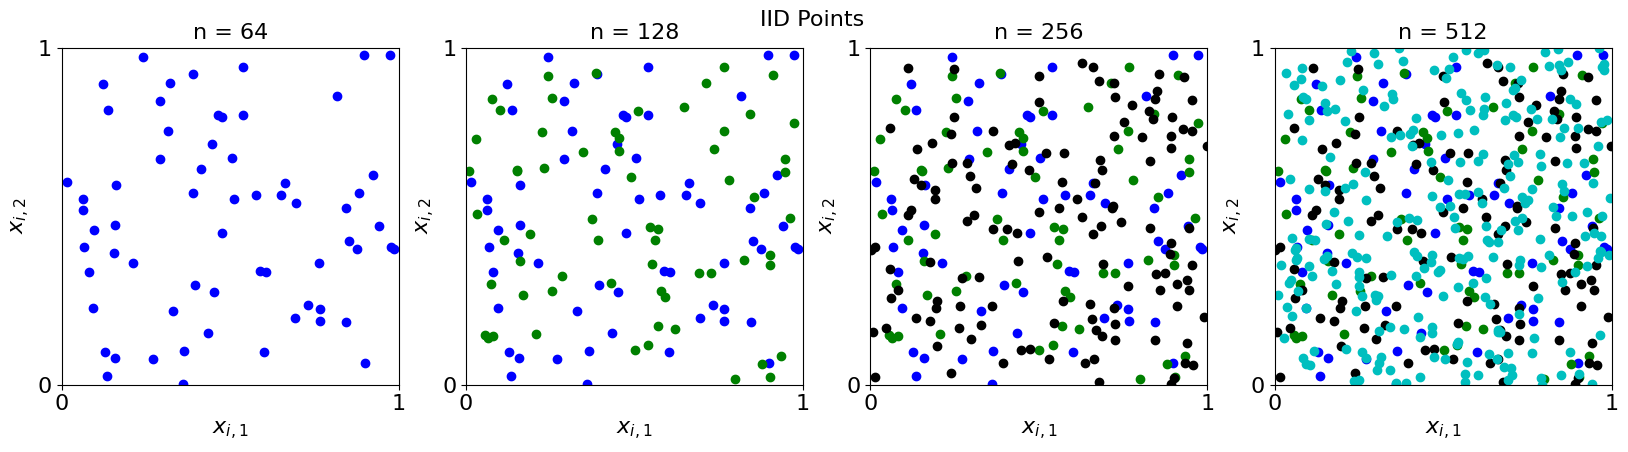

In [26]:
iid = qp.IIDStdUniform(d) #define the generator
xpts = ld.gen_samples(n) #generate points
xpts
fig = plot_successive_points(iid,'IID',first_n=n,n_cols=4)
fig.savefig(figpath+'iidpts.eps',format='eps')

## Beam Example
### Set up the problem using a docker container to solve the ODE

In [6]:
import umbridge #this is the connector
!unset DOCKER_*
!docker run --name muqbp -d -it -p 4243:4243 linusseelinger/benchmark-muq-beam-propagation:latest #get beam example
d = 3 #dimension of the randomness
umbridge_config = {"d": d}
model = umbridge.HTTPModel('http://localhost:4243','forward')

zsh:1: no matches found: DOCKER_*
docker: Error response from daemon: Conflict. The container name "/muqbp" is already in use by container "45b38234ce7661bf2a67d47dc3f9586790d947651d4ca6854a1859b8b07146f9". You have to remove (or rename) that container to be able to reuse that name.
See 'docker run --help'.



Cantilever Beam



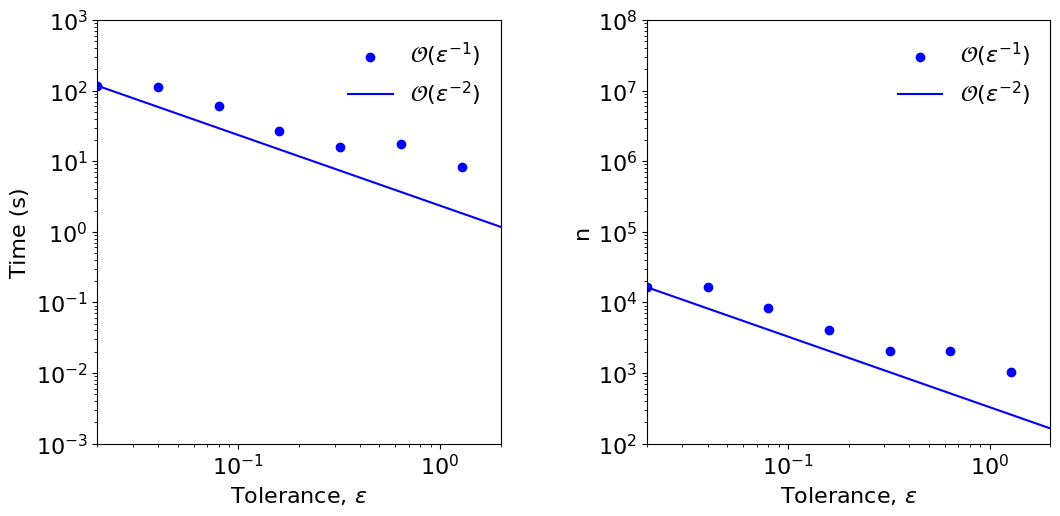

In [7]:
ld = qp.Uniform(qp.Lattice(d,seed=7),lower_bound=1,upper_bound=1.2) #lattice points for this problem
ld_integ = qp.UMBridgeWrapper(ld,model,umbridge_config,parallel=False) #integrand
tol = 0.02  #smallest tolerance

n_tol = 8
#ii_iid = 2  #make this larger to reduce the time required
tol_vec = [tol*(2**ii) for ii in range(n_tol)]  #initialize vector of tolerances
ld_time = [0]*n_tol; ld_n = [0]*n_tol  #low discrepancy time and number of function values
#iid_time = [0]*n_tol; iid_n = [0]*n_tol  #IID time and number of function values
for ii in range(n_tol):
  solution, data = qp.CubQMCLatticeG(ld_integ, abs_tol = tol_vec[ii]).integrate()
  if ii == 0: 
    print(f'\nCantilever Beam\n')
  ld_time[ii] = data.time_integrate
  ld_n[ii] = data.n_total
  #if ii >= ii_iid:
  #  solution, data = qmcpy.CubMCG(iid_keister, abs_tol = tol_vec[ii]).integrate()
  #  iid_time[ii] = data.time_integrate
  #  iid_n[ii] = data.n_total
fig,ax = plt.subplots(nrows=1,ncols=2,figsize=(13,5.5))
ax[0].scatter(tol_vec[0:n_tol],ld_time[0:n_tol],color='b'); 
ax[0].plot(tol_vec[0:n_tol],[(ld_time[0]*tol_vec[0])/tol_vec[jj] for jj in range(n_tol)],color='b')
#ax[0].scatter(tol_vec[ii_iid:n_tol],iid_time[ii_iid:n_tol],color='g'); 
#ax[0].plot(tol_vec[ii_iid:n_tol],[(iid_time[ii_iid]*(tol_vec[ii_iid]**2))/(tol_vec[jj]**2) for jj in range(ii_iid,n_tol)],color='g')
ax[0].set_ylim([0.001,1000]); ax[0].set_ylabel('Time (s)')
ax[1].scatter(tol_vec[0:n_tol],ld_n[0:n_tol],color='b'); 
ax[1].plot(tol_vec[0:n_tol],[(ld_n[0]*tol_vec[0])/tol_vec[jj] for jj in range(n_tol)],color='b')
#ax[1].scatter(tol_vec[ii_iid:n_tol],iid_n[ii_iid:n_tol],color='g'); 
#ax[1].plot(tol_vec[ii_iid:n_tol],[(iid_n[ii_iid]*(tol_vec[ii_iid]**2))/(tol_vec[jj]**2) for jj in range(ii_iid,n_tol)],color='g')
ax[1].set_ylim([1e2,1e8]); ax[1].set_ylabel('n')
for ii in range(2):
  ax[ii].set_xlim([tol,100*tol]); ax[ii].set_xlabel('Tolerance, '+r'$\varepsilon$')
  ax[ii].set_xscale('log'); ax[ii].set_yscale('log')
  ax[ii].legend([r'$\mathcal{O}(\varepsilon^{-1})$',r'$\mathcal{O}(\varepsilon^{-2})$','LD','IID'],frameon=False)
  ax[ii].set_aspect(0.35)

In [8]:
print(data)

LDTransformData (AccumulateData Object)
    solution        [   0.       4.097   15.631 ...  960.504  998.786 1037.103]
    comb_bound_low  [   0.       4.093   15.618 ...  959.479  997.717 1035.992]
    comb_bound_high [   0.       4.1     15.644 ...  961.53   999.854 1038.215]
    comb_flags      [ True  True  True ...  True  True  True]
    n_total         2^(10)
    n               [1024. 1024. 1024. ... 1024. 1024. 1024.]
    time_integrate  6.948
CubQMCLatticeG (StoppingCriterion Object)
    abs_tol         2.560
    rel_tol         0
    n_init          2^(10)
    n_max           2^(35)
UMBridgeWrapper (Integrand Object)
Uniform (TrueMeasure Object)
    lower_bound     1
    upper_bound     1.200
Lattice (DiscreteDistribution Object)
    d               3
    dvec            [0 1 2]
    randomize       1
    order           natural
    gen_vec         [     1 182667 469891]
    entropy         7
    spawn_key       ()



Cantilever Beam



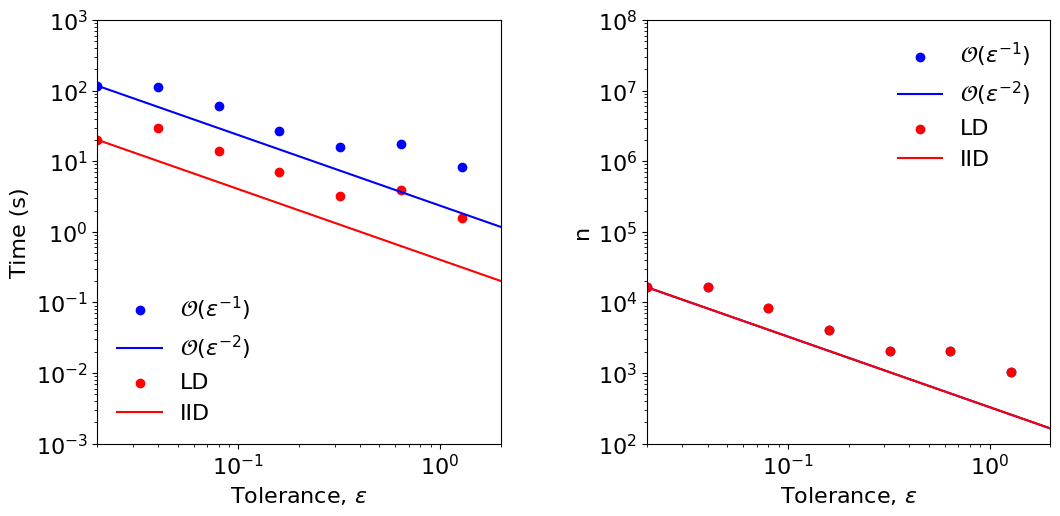

In [9]:
ld_integ_p = qp.UMBridgeWrapper(ld,model,umbridge_config,parallel=12) #integrand with parallel processing

ld_p_time = [0]*n_tol; ld_p_n = [0]*n_tol  #low discrepancy time and number of function values with parallel
for ii in range(n_tol):
  solution, data = qp.CubQMCLatticeG(ld_integ_p, abs_tol = tol_vec[ii]).integrate()
  if ii == 0: 
    print(f'\nCantilever Beam\n')
  ld_p_time[ii] = data.time_integrate
  ld_p_n[ii] = data.n_total
  #if ii >= ii_iid:
  #  solution, data = qmcpy.CubMCG(iid_keister, abs_tol = tol_vec[ii]).integrate()
  #  iid_time[ii] = data.time_integrate
  #  iid_n[ii] = data.n_total
fig,ax = plt.subplots(nrows=1,ncols=2,figsize=(13,5.5))
ax[0].scatter(tol_vec[0:n_tol],ld_time[0:n_tol],color='b'); 
ax[0].plot(tol_vec[0:n_tol],[(ld_time[0]*tol_vec[0])/tol_vec[jj] for jj in range(n_tol)],color='b')
ax[0].scatter(tol_vec[0:n_tol],ld_p_time[0:n_tol],color='r'); 
ax[0].plot(tol_vec[0:n_tol],[(ld_p_time[0]*tol_vec[0])/tol_vec[jj] for jj in range(n_tol)],color='r')
#ax[0].scatter(tol_vec[ii_iid:n_tol],iid_time[ii_iid:n_tol],color='g'); 
#ax[0].plot(tol_vec[ii_iid:n_tol],[(iid_time[ii_iid]*(tol_vec[ii_iid]**2))/(tol_vec[jj]**2) for jj in range(ii_iid,n_tol)],color='g')
ax[0].set_ylim([0.001,1000]); ax[0].set_ylabel('Time (s)')
ax[1].scatter(tol_vec[0:n_tol],ld_n[0:n_tol],color='b'); 
ax[1].plot(tol_vec[0:n_tol],[(ld_n[0]*tol_vec[0])/tol_vec[jj] for jj in range(n_tol)],color='b')
ax[1].scatter(tol_vec[0:n_tol],ld_p_n[0:n_tol],color='r'); 
ax[1].plot(tol_vec[0:n_tol],[(ld_p_n[0]*tol_vec[0])/tol_vec[jj] for jj in range(n_tol)],color='r')
#ax[1].scatter(tol_vec[ii_iid:n_tol],iid_n[ii_iid:n_tol],color='g'); 
#ax[1].plot(tol_vec[ii_iid:n_tol],[(iid_n[ii_iid]*(tol_vec[ii_iid]**2))/(tol_vec[jj]**2) for jj in range(ii_iid,n_tol)],color='g')
ax[1].set_ylim([1e2,1e8]); ax[1].set_ylabel('n')
for ii in range(2):
  ax[ii].set_xlim([tol,100*tol]); ax[ii].set_xlabel('Tolerance, '+r'$\varepsilon$')
  ax[ii].set_xscale('log'); ax[ii].set_yscale('log')
  ax[ii].legend([r'$\mathcal{O}(\varepsilon^{-1})$',r'$\mathcal{O}(\varepsilon^{-2})$','LD','IID'],frameon=False)
  ax[ii].set_aspect(0.35)

In [10]:
!docker rm -f muqbp #shut down docker image

IOStream.flush timed out
IOStream.flush timed out
muqbp


## Below is long-running code, that we rarely wish to run

In [11]:
assert False

AssertionError: 

In [ ]:
print('Hi')

In [ ]:
sampler = qp.Uniform(qp.Lattice(d,seed=7),lower_bound=1,upper_bound=1.05) #lattice points for this problem
integrand = qp.UMBridgeWrapper(sampler,model,umbridge_config,parallel=False) #integrand
stop = qp.CubQMCLatticeG(integrand,abs_tol=1) #stoppng criterion
solution,data = stop.integrate()
data

In [ ]:
sampler = qp.Uniform(qp.IIDStdUniform(3,seed=7),lower_bound=1,upper_bound=1.05) #iid points for this problem
integrand = qp.UMBridgeWrapper(sampler,model,umbridge_config,parallel=False) # INTEGRAND
iid_mc_stop = qp.CubMCCLT(integrand,abs_tol=100) # QMC STOPPING CRITERION
#solution,data = iid_mc_stop.integrate()
data